In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

##1. Obtener una detección del logo en cada imagen sin falsos positivos

In [ ]:
def laplacian_pyramid(img):
  base = img.copy()

  # Creamos la pirámide Gaussiana
  piramide_gauss = [base]
  for i in range(2):
      base = cv.pyrDown(base)
      piramide_gauss.append(base)

  # El último nivel de la Gaussiana permanece en el mismo lugar en la Laplaciana
  punta_laplaciana = piramide_gauss[-1]

  # Creamos la pirámide Laplaciana
  piramide_laplace = [punta_laplaciana]
  for i in range(2,0,-1):
      size = (piramide_gauss[i - 1].shape[1], piramide_gauss[i - 1].shape[0])
      gaussiana_expandida = cv.pyrUp(piramide_gauss[i], dstsize=size)
      laplaciana = cv.subtract(piramide_gauss[i-1], gaussiana_expandida)
      print(laplaciana.shape)
      piramide_laplace.append(laplaciana)
      #cv.imshow('nivel-{}'.format(i-1),laplaciana)

  return piramide_laplace

In [ ]:
def img_scaling(img):

  print(f'Tamaño original: {img.shape}')
  scales = np.linspace(1, 1/6, 5)
  resized_imgs = list()

  # generamos nuestra "piramide" de tamaños arbitrarios
  print(f'Dimensiones generadas:')
  for scale in scales:
      resized_imgs.append(cv.resize(img, None, fx=scale, fy=scale))
      print(resized_imgs[-1].shape)

  return resized_imgs

In [ ]:
def sobel_xy(gray):
  # Calculamos el gradiente usando la derivada de Sobel
  sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0)
  sobely = cv.Sobel(gray, cv.CV_64F, 0, 1)

  # Tomamos el valor absoluto del gradiente
  sobelx = np.absolute(sobelx)
  sobely = np.absolute(sobely)

  # Sumamos las gradientes en x e y
  sobel_combined = sobelx + sobely

  # Encontramos el máximo de sobel_combined
  maxGradient = np.max(sobel_combined)

  return maxGradient

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compare_images(image1, image2):
    # Verificar que ambas imágenes tengan las mismas dimensiones
    if image1.shape != image2.shape:
        raise ValueError("Las imágenes deben tener las mismas dimensiones.")

    # Calcular el índice de similitud estructural (SSIM) entre las imágenes
    similarity = ssim(image1, image2)

    #print(f"Similutud: {similarity}")
    return similarity

In [ ]:
def resize(img):
  print('\nTamaño imagen: {} pix'.format(img.shape))

  #Nivel 1
  img_nivel_1 = cv.pyrDown(img)
  print('\nTamaño imagen: {} pix'.format(img_nivel_1.shape))

  #Nivel 2
  img_nivel_2 = cv.pyrDown(img_nivel_1)
  print('\nTamaño imagen: {} pix'.format(img_nivel_2.shape))

  #Nivel 3
  img_nivel_3 = cv.pyrDown(img_nivel_2)
  print('\nTamaño imagen: {} pix'.format(img_nivel_3.shape))

  return [img, img_nivel_1, img_nivel_2,img_nivel_3]

In [ ]:
#El metodo de template matching se uso con correlación normalizada, apesar de que
#en uno de los 4 niveles del template siempre se encontró una coincidencia muy buena,
#esta no representaba el valor maximo por lo cual se implementó una funcion que
#comparaba la ubicación que arroja el metodo con el correspondiente nivel del template
#de esta manera se pudó seleccionar la mejor coincidencia, sin embargo cuando el logo
#a detectar en la imagen es muy pequeño funciona mejor el maximo que arroja el metodo

def template_match(template_list,img,img2,image):

  #almacenar puntaje de cada imagen sobre el metodo
  template_scaling_score=[]

  for template in template_list:
    w, h = template.shape[::-1]
    img = img2.copy()
    methods = ['cv.TM_CCORR_NORMED']

    for meth in methods:
      #print(f"tamaño del template: {template.shape}")
      #print(f"tamaño de la imagen: {img.shape}")
      method = eval(meth)

      # Apply template Matching
      res = cv.matchTemplate(img,template,method)
      min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
      # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
      if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
          top_left = min_loc
      else:
          top_left = max_loc
      #print(f"valor maximo: {max_val}\nvalor minimo: {min_val}")

      a=img[top_left[1]:top_left[1]+h,top_left[0]:top_left[0]+w]
      b=template
      similitud=compare_images(a,b)
      if image == "coca_retro_2.png" or image == "coca_multi.png":
        template_scaling_score.append(max_val)
      else:
        template_scaling_score.append(similitud)

  print(template_scaling_score)
  print(template_scaling_score.index(max(template_scaling_score)))
  return template_scaling_score.index(max(template_scaling_score))


#hace un plot de la mejor coincidencia del template en la imagen
def plot_match(img,template,img_rgb):
  w, h = template.shape[::-1]
  img = img2.copy()
  # Apply template Matching
  res = cv.matchTemplate(img,template,cv.TM_CCORR_NORMED)
  min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
  # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
  top_left = max_loc
  a=img[top_left[1]:top_left[1]+h,top_left[0]:top_left[0]+w]
  b=template
  similitud=compare_images(a,b)
  print(f"Similitud {similitud}")

  bottom_right = (top_left[0] + w, top_left[1] + h)
  cv.rectangle(img_rgb,top_left, bottom_right, (255,255,0), 5)
  plt.subplot(121),plt.imshow(res,cmap = 'gray')
  plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(img_rgb)
  plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
  plt.suptitle("cv.TM_CCORR_NORMED")
  plt.show()


Tamaño original: (175, 400)
Dimensiones generadas:
(175, 400)
(139, 317)
(102, 233)
(66, 150)
(29, 67)


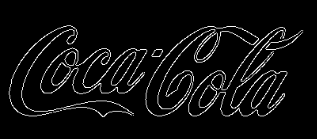

In [ ]:
#se carga el template
template= cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE)
assert template is not None, "file could not be read, check with os.path.exists()"

#se aplica binarización para tratar de localizar el logo mas rapido
_, template = cv.threshold(~template, 100, 255, cv.THRESH_BINARY)

#uso los gradientes para ajustar los limites en el detector de bordes de canny
max_gradient=sobel_xy(template)
threshold1 = 0.01 * max_gradient
threshold2 = 0.1 * max_gradient
template = cv.Canny(template,threshold1,threshold2)

#genero un piramide de 4 niveles
list_template=img_scaling(template)

#template luego de transformaciones
cv2_imshow(list_template[1])
#cv.imshow(list_template[1])

[0.46242249729832297, 0.35189268281754765, 0.33249402165729924, 0.2189413815259684, 0.0946172624360265]
0
Similitud 0.46242249729832297


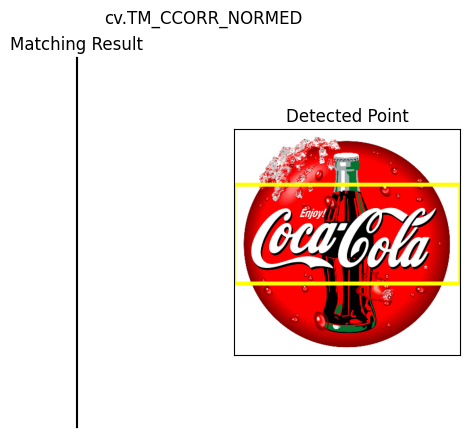

[0.39535932520850287, 0.39129307955748, 0.2550081198080427, 0.17484706193892993, 0.10134733464923104]
0
Similitud 0.39535932520850287


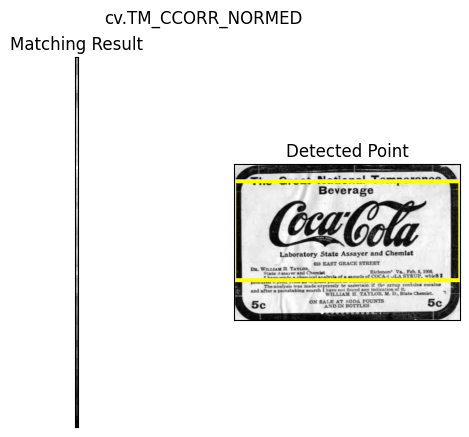

[0.06010875850915909, 0.09117516875267029, 0.13566400110721588, 0.1720166951417923, 0.31045669317245483]
4
Similitud 0.14144441402680635


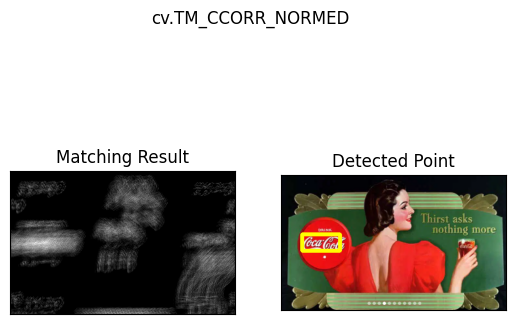

[0.5540902165888512, 0.49965524058462596, 0.39071634103208985, 0.2580678691764366, 0.10851151700119313]
0
Similitud 0.5540902165888512


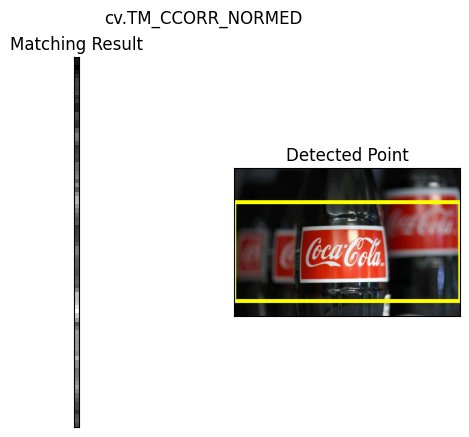

[0.4625562539577715, 0.4676743948910436, 0.26724899571371, 0.1575493185397198, 0.10471024462047865]
1
Similitud 0.4676743948910436


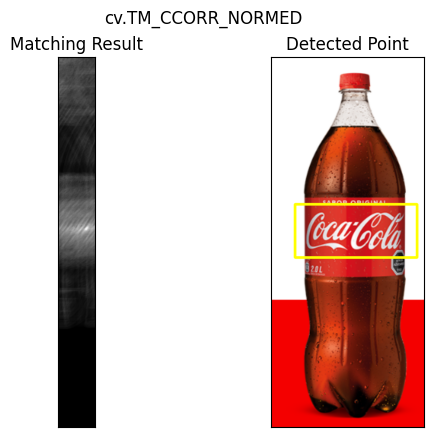

[0.4326620968694707, 0.3183298760299494, 0.22389762984900013, 0.19822641800067786, 0.05761274506985895]
0
Similitud 0.4326620968694707


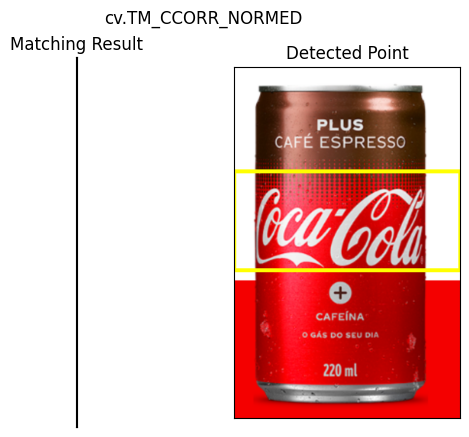

[0.10751274973154068, 0.1468806266784668, 0.15500576794147491, 0.18958887457847595, 0.31300801038742065]
4
Similitud 0.14526624946985178


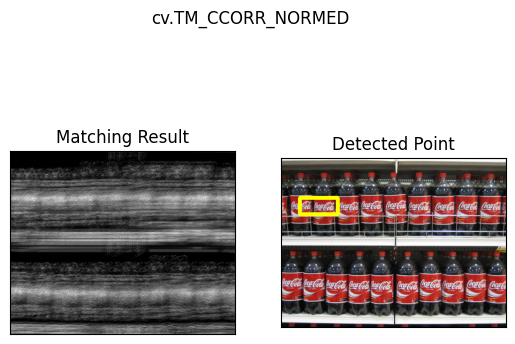

In [ ]:
#Se recorre cada imagen y se va ajustando a un ancho 400 y la altura se ajusta segun la relación
#la idea es recorrer los 4 niveles del template para cada imagen y seleccionar la mejor puntuación
imagenes=["COCA-COLA-LOGO.jpg", "coca_retro_1.png", "coca_retro_2.png", "logo_1.png","coca_logo_1.png", "coca_logo_2.png","coca_multi.png"]
for image in imagenes:
  path='./images/'+image

  #invierto el color de este logo, apesar de que se aplica bordes la deteccion mejora si antes se invierte
  #al mismo color del logo del template
  if image == "coca_retro_1.png":
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    img =~img
  else:
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)

  #aplico binarización
  _, img = cv.threshold(img, 200, 255, cv.THRESH_BINARY)

  img_c = cv.imread(path)
  img_rgb= cv.cvtColor(img_c, cv.COLOR_BGR2RGB)

  #utilizó los gradientes para los umbrales en el detector de bordes
  max_gradient=sobel_xy(img)
  threshold1 = 0.01 * max_gradient
  threshold2 = 0.50 * max_gradient
  img = cv.Canny(img,threshold1,threshold2)

  #ajusto cada imagen a un ancho igual a del template original
  ancho=400
  if img.shape[1]<ancho:
    scale=ancho/img.shape[1]
    img = cv.resize(img, None, fx=scale, fy=scale)
    img_rgb = cv.resize(img_rgb, None, fx=scale, fy=scale)
  else:
    scale=ancho/img.shape[1]
    img = cv.resize(img, None, fx=scale, fy=scale)
    img_rgb = cv.resize(img_rgb, None, fx=scale, fy=scale)

  img2=img.copy()

  #envio los 4 niveles del template y cada imagen transformada
  index=template_match(list_template,img,img2,image)
  #grafico el mejor resultado
  plot_match(img,list_template[index],img_rgb)

##2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo template del ítem 1

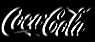

resolución de imagen: (598, 799, 3)
resolución de template: (42, 95)


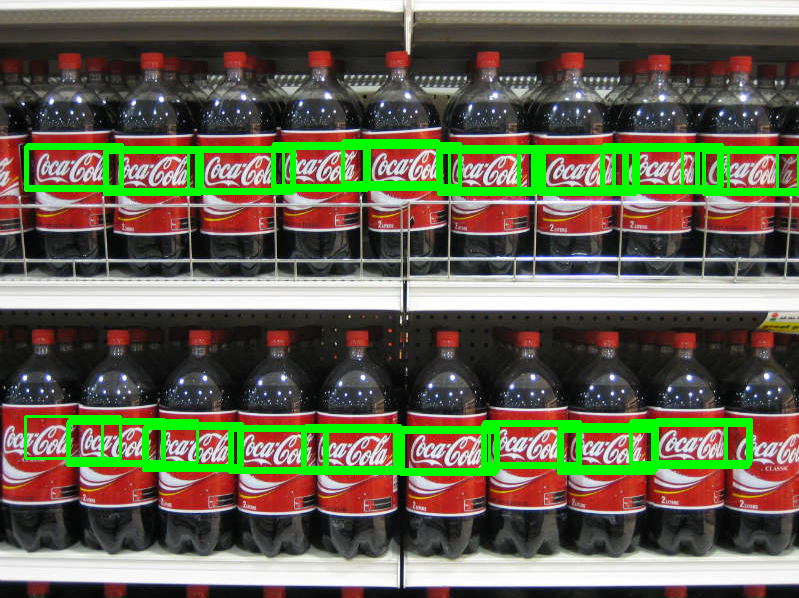

In [ ]:
img_rgb= cv.imread('./images/coca_multi.png')
assert template is not None, "file could not be read, check with os.path.exists()"

template= cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE)
assert template is not None, "file could not be read, check with os.path.exists()"

#Se ajusto el tamaño del template al valor promedio del template en la imagen
template = cv.resize(~template, (95,42), interpolation = cv.INTER_AREA)
#Se usó sobel en dirección horizontal
template = cv.Sobel(template,cv.CV_8U,1,0,ksize=3)
cv2_imshow(template)

print(f"resolución de imagen: {img_rgb.shape}")
print(f"resolución de template: {template.shape}")

img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
img_gray = cv.Sobel(img_gray,cv.CV_8U,1,0,ksize=3)


w, h = template.shape[::-1]
res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
threshold = 0.207

loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)

cv2_imshow(img_rgb)